In [1]:
# Usual imports
import pandas as pd
import seaborn as sns
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from scalecast.Forecaster import Forecaster
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
%matplotlib inline

# if your Jupyter kernel crashes during this code, use this setting
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [3]:
# Read csv file into dataframe
df = pd.read_csv("../ready_data/winter_2021.csv")
df = df.rename({"Friction": "y"}, axis=1)
df.head()

,ts,airTemp,humidity,dewpoint,precipitation,y,Road_Surface_Temperature,Water_Film_Surface_mm
0,2021-11-01 00:00:00,8.8,94.0,7.9,0.0,0.82,5.082435,0.0
1,2021-11-01 00:10:00,9.1,91.0,7.7,0.0,0.82,5.035252,0.0
2,2021-11-01 00:20:00,9.1,90.0,7.5,0.0,0.82,4.951386,0.0
3,2021-11-01 00:30:00,9.2,88.0,7.3,0.0,0.82,5.077870,0.0
4,2021-11-01 00:40:00,9.2,86.0,7.0,0.0,0.82,4.919721,0.0


In [4]:
f = Forecaster(y=df.y,
               current_dates=df.ts,
               future_dates=12)
f

Forecaster(
    DateStartActuals=2021-11-01T00:00:00.000000000
    DateEndActuals=2022-03-31T23:50:00.000000000
    Freq=10min
    N_actuals=21744
    ForecastLength=12
    Xvars=[]
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [5]:
f.set_test_length(.15)     
f.set_estimator('lstm')

In [26]:
def add_lagged_series(f):
    f.add_series(series=df.airTemp, called="airtemp")
    f.add_series(series=df.humidity, called="humidity")
    f.add_series(series=df.dewpoint, called="dewpoint")
    f.add_series(series=df.precipitation, called="precipitation")
    f.add_series(series=df.airTemp, called="Road_Surface_Temperature")
    f.add_series(series=df.airTemp, called="Water_Film_Surface_mm")
    f.add_lagged_terms('airtemp', 'humidity', 'dewpoint', 'precipitation', 'Road_Surface_Temperature', 'Water_Film_Surface_mm', lags=24) # adds first, second, and third lag of t called 'tlag_1' - 'tlag_3
    return f


Epoch 1/50

380/380 [==============================] - 12s 20ms/step - loss: 0.1803 - val_loss: 0.1663
Epoch 2/50
380/380 [==============================] - 7s 18ms/step - loss: 0.1332 - val_loss: 0.1620
Epoch 3/50
380/380 [==============================] - 6s 17ms/step - loss: 0.1325 - val_loss: 0.1621
Epoch 4/50
380/380 [==============================] - 6s 17ms/step - loss: 0.1304 - val_loss: 0.1610
Epoch 5/50
380/380 [==============================] - 6s 17ms/step - loss: 0.1296 - val_loss: 0.1630
Epoch 6/50
380/380 [==============================] - 6s 17ms/step - loss: 0.1293 - val_loss: 0.1664
Epoch 7/50
380/380 [==============================] - 7s 17ms/step - loss: 0.1289 - val_loss: 0.1629
Epoch 8/50
380/380 [==============================] - 7s 17ms/step - loss: 0.1289 - val_loss: 0.1642
Epoch 9/50
380/380 [==============================] - 6s 17ms/step - loss: 0.1289 - val_loss: 0.1636
Epoch 10/50
380/380 [==============================] - 7s 17ms/step - loss: 0.1288 - val

c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\scalecast\_utils.py:60: Warning: Confidence intervals not found for lstm_with_lagged_series. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


<Axes: xlabel='Date', ylabel='Values'>

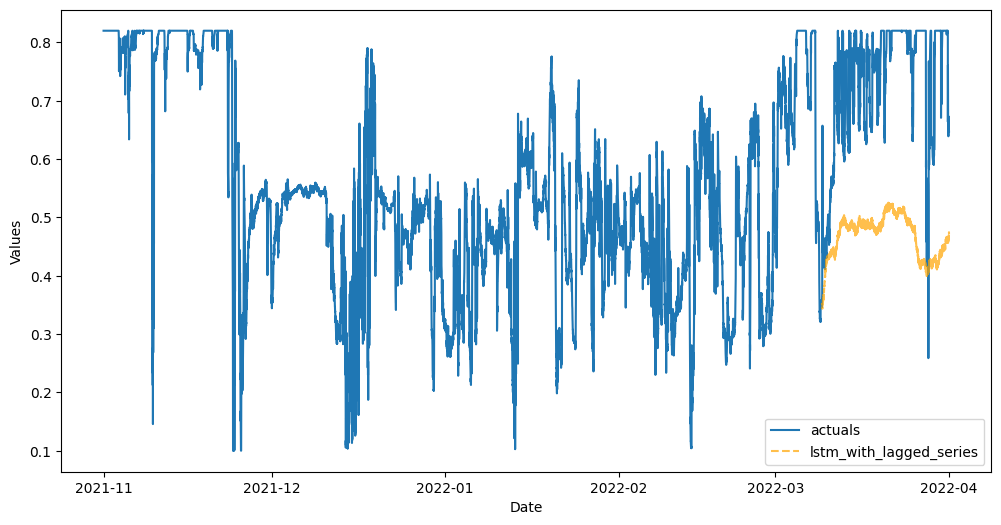

In [ ]:
f.manual_forecast(call_me='lstm_with_lagged_series',
                  lags=36,
                  epochs=50,
                  validation_split=.2,
                  shuffle=True,
                  callbacks=EarlyStopping(monitor='val_loss', patience=8),
                  lstm_layer_sizes=(16,16,16),
                  dropout=(0,0,0))
f.plot_test_set(ci=True)

In [12]:
test_df = pd.read_csv("../ready_data/test_day.csv")
test_df = test_df.rename({"Friction": "y"}, axis=1)

In [22]:
f.save_tf_model(name='model.h5') # default argument

c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


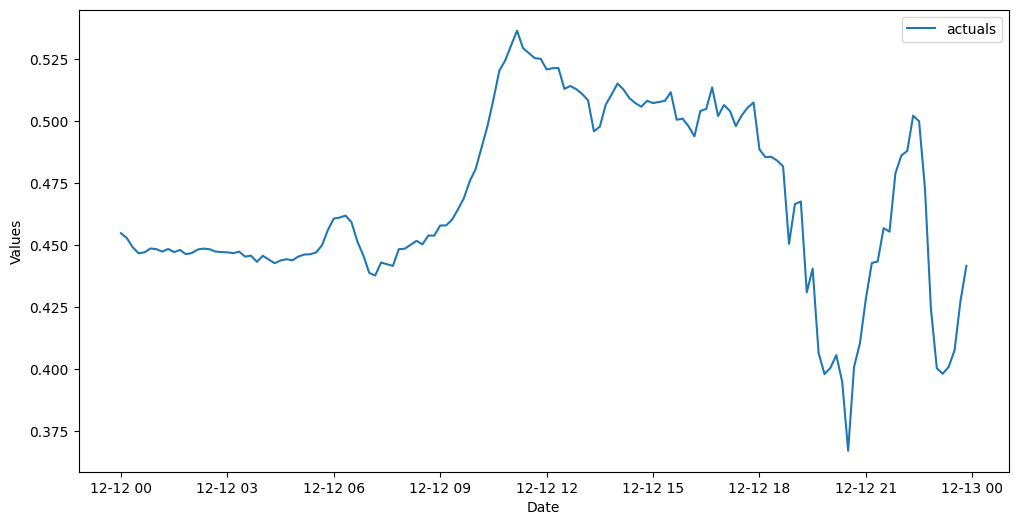

In [ ]:
f_new = Forecaster(
    y = test_df.y,
    current_dates = test_df.ts,
    future_dates = 48,
)

f_new.plot()
plt.show()

In [14]:
from scalecast.util import infer_apply_Xvar_selection, find_optimal_transformation

In [27]:
f_new = infer_apply_Xvar_selection(infer_from=f,apply_to=f_new)
f_new = add_lagged_series(f_new)
f_new

c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\scalecast\util.py:601: Warning: The inference was unable to guess the following variables: ['airtemp', 'humidity', 'dewpoint', 'precipitation', 'Road_Surface_Temperature', 'Water_Film_Surface_mm', 'airtemplag_1', 'airtemplag_2', 'airtemplag_3', 'airtemplag_4', 'airtemplag_5', 'airtemplag_6', 'airtemplag_7', 'airtemplag_8', 'airtemplag_9', 'airtemplag_10', 'airtemplag_11', 'airtemplag_12', 'airtemplag_13', 'airtemplag_14', 'airtemplag_15', 'airtemplag_16', 'airtemplag_17', 'airtemplag_18', 'airtemplag_19', 'airtemplag_20', 'airtemplag_21', 'airtemplag_22', 'airtemplag_23', 'airtemplag_24', 'humiditylag_1', 'humiditylag_2', 'humiditylag_3', 'humiditylag_4', 'humiditylag_5', 'humiditylag_6', 'humiditylag_7', 'humiditylag_8', 'humiditylag_9', 'humiditylag_10', 'humiditylag_11', 'humiditylag_12', 'humiditylag_13', 'humiditylag_14', 'humiditylag_15', 'humiditylag_16', 'humiditylag_17', 'humiditylag_18', 'humiditylag_19', 'hum

Forecaster(
    DateStartActuals=2023-12-12T00:00:00.000000000
    DateEndActuals=2023-12-12T23:50:00.000000000
    Freq=10min
    N_actuals=144
    ForecastLength=48
    Xvars=['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'AR29', 'AR30', 'AR31', 'AR32', 'AR33', 'AR34', 'AR35', 'AR36', 'airtemp', 'humidity', 'dewpoint', 'precipitation', 'Road_Surface_Temperature', 'Water_Film_Surface_mm', 'airtemplag_1', 'airtemplag_2', 'airtemplag_3', 'airtemplag_4', 'airtemplag_5', 'airtemplag_6', 'airtemplag_7', 'airtemplag_8', 'airtemplag_9', 'airtemplag_10', 'airtemplag_11', 'airtemplag_12', 'airtemplag_13', 'airtemplag_14', 'airtemplag_15', 'airtemplag_16', 'airtemplag_17', 'airtemplag_18', 'airtemplag_19', 'airtemplag_20', 'airtemplag_21', 'airtemplag_22', 'airtemplag_23', 'airtemplag_24', 'humiditylag_1', 'humiditylag_2', 'humi

ValueError: All arrays must be of the same length

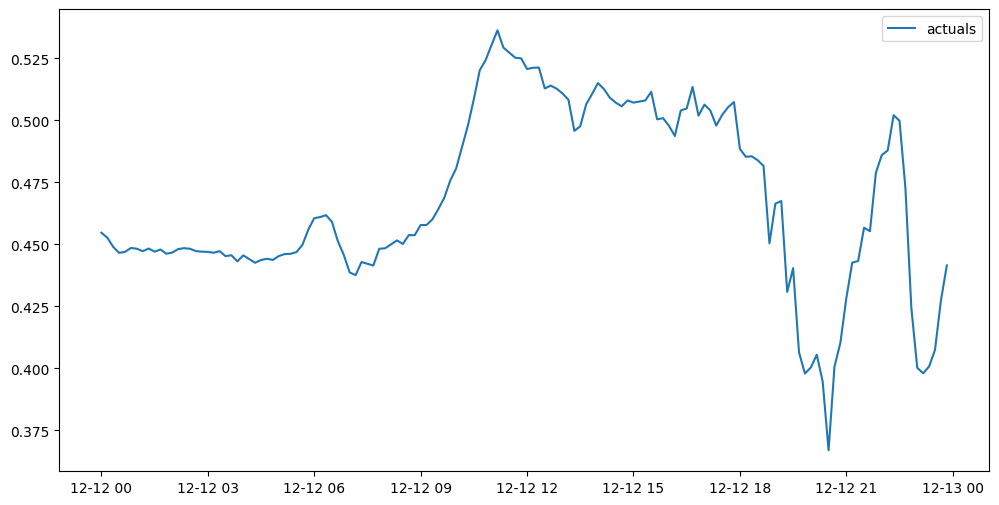

In [31]:
f_new.plot()
plt.show()

In [29]:
f_new.transfer_predict(transfer_from=f,model='lstm_with_lagged_series',model_type='tf')

2/2 [==============================] - 0s 5ms/step


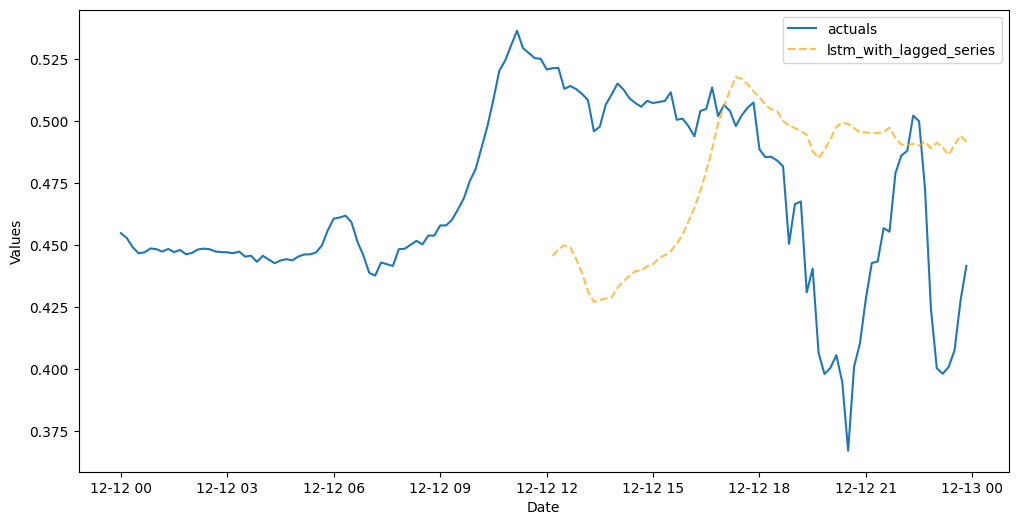

In [30]:
f_new.plot_fitted()
plt.show()